In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets

In [56]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"
model_names = ['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft']
data_dict = {}

for model in model_names:
    file = f"test_softmax_outputs_{model}.csv"
    data_dict[model] = pd.read_csv(f"{path}/{file}")
print(data_dict.keys())

dict_keys(['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft'])


In [3]:
#only change the model name here
model = "lstm"

In [57]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"
file = f"test_softmax_outputs_{model}.csv"

In [5]:
df = pd.read_csv(f"{path}/{file}")

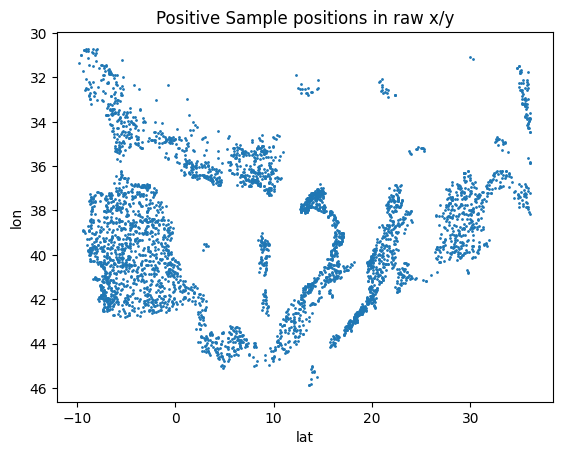

In [40]:
#lon = x, lat = y
plt.scatter(df['lat'], df['lon'], s=1)
plt.title("Positive Sample positions in raw x/y")
plt.xlabel("lat")
plt.ylabel("lon")
plt.gca().invert_yaxis()  # Wenn Bildkoordinaten (0 oben)
plt.show()

In [7]:
df

,prob,lat,lon,sample_id,label,log_burned_area
0,0.875692,-7.255371,40.379097,1662,1,5.568345
1,0.003264,-1.093160,38.838545,14895,0,3.401197
2,0.987730,13.617607,37.861855,3208,1,3.663562
3,0.136869,-2.180609,37.297992,15287,0,3.401197
4,0.446271,-4.768335,40.147511,15348,0,3.401197
...,...,...,...,...,...,...
4102,0.002661,-2.814954,36.844888,16247,0,3.401197
4103,0.747508,16.044230,44.034134,6129,1,3.433987
4104,0.001865,17.071265,39.201028,15925,0,3.401197
4105,0.439884,-6.369302,33.411369,15446,0,3.401197


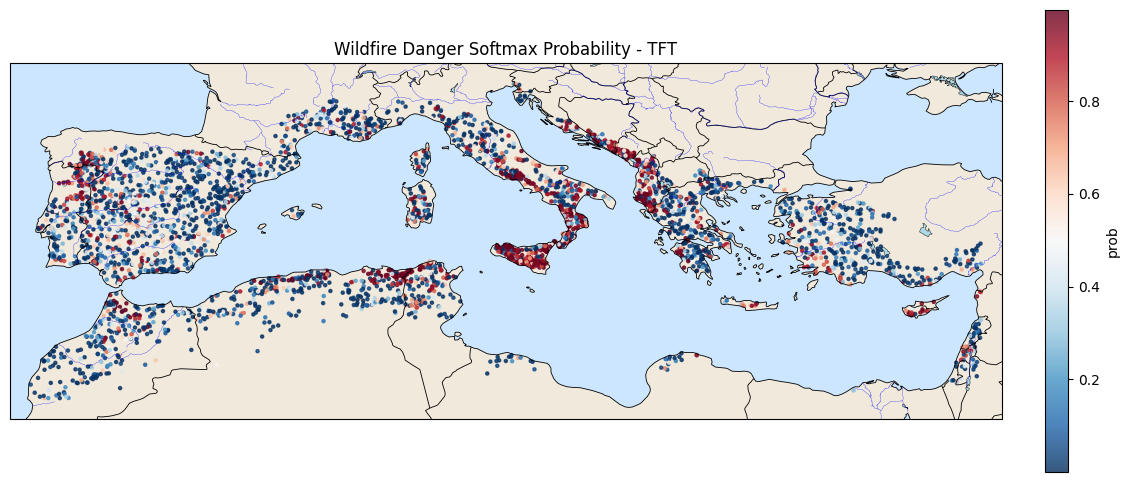

In [58]:
x = df['lat']
y = df['lon']
influence_variable = df['prob'] #softmax probability of each validation sample

# Plot mit Cartopy
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([x.min() - 1, x.max() + 1, y.min() - 1, y.max() + 1], crs=ccrs.PlateCarree())
#ax.stock_img()

# Features hinzufügen
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

# Scatter mit Farbe nach Population
sc = ax.scatter(x, y, c=influence_variable, cmap='RdBu_r', s=5, alpha=0.8, vmin=influence_variable.min(), vmax=influence_variable.max(), transform=ccrs.PlateCarree())

# Farbskala
cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cb.set_label(f'{influence_variable.name}')

# Titel
plt.title("Wildfire Danger Softmax Probability - TFT")

plt.show()

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
import os

# Pfad zur CSV-Datei
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/test_softmax_csv"

# Liste der Modellnamen
model_names = ['cnn', 'mlp', 'gru', 'lstm', 'transformer', 'gtn', 'tft']

# Dropdown-Widget für Modell- und Label-Auswahl
model_selector = widgets.Dropdown(
    options=model_names,
    value="transformer",
    description="Model:"
)

label_selector = widgets.Dropdown(
    options=["all", "positive", "negative"],
    value="all",
    description="Label:"
)

# Plotfunktion
def plot_softmax_map(model, label_filter):
    file = f"test_softmax_outputs_{model}.csv"
    filepath = os.path.join(path, file)

    if not os.path.exists(filepath):
        print(f"File not found for model: {model}")
        return

    df = pd.read_csv(filepath)
    df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)

    if label_filter == "positive":
        data = df[df["label"] == 1]
    elif label_filter == "negative":
        data = df[df["label"] == 0]
    else:
        data = df

    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([data["lat"].min() - 1, data["lat"].max() + 1,
                   data["lon"].min() - 1, data["lon"].max() + 1],
                  crs=ccrs.PlateCarree())

    # Basemap
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#ffffff') #f0e9dc
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

    sc = ax.scatter(
        data["lat"], data["lon"],
        c=data["prob"],
        cmap='RdBu_r', #Spectral_r, turbo, RdBu_r
        s=5, alpha=0.8,
        vmin=df["prob"].min(), vmax=df["prob"].max(),
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label("Softmax Probability")

    plt.title(f"Wildfire Danger Softmax Probability - {model.upper()} ({label_filter})")
    plt.show()

# Interaktive Widgets kombinieren
widgets.interact(plot_softmax_map, model=model_selector, label_filter=label_selector);


interactive(children=(Dropdown(description='Model:', index=4, options=('cnn', 'mlp', 'gru', 'lstm', 'transform…

In [53]:
from scipy.interpolate import griddata

def plot_softmax_map(model, label_filter):
    file = f"test_softmax_outputs_{model}.csv"
    filepath = os.path.join(path, file)

    if not os.path.exists(filepath):
        print(f"File not found for model: {model}")
        return

    df = pd.read_csv(filepath)
    df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)

    if label_filter == "positive":
        data = df[df["label"] == 1]
    elif label_filter == "negative":
        data = df[df["label"] == 0]
    else:
        data = df

    grid_lon = np.linspace(data["lon"].min(), data["lon"].max(), 500)  # X-Achse
    grid_lat = np.linspace(data["lat"].min(), data["lat"].max(), 500)  # Y-Achse
    #grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    lon_min, lon_max = -10, 40    # z. B. von Spanien bis Türkei
    lat_min, lat_max = 30, 50     # z. B. Nordafrika bis Mitteleuropa
    
    # Schritt 2: Regelmäßiges Raster in diesem Bereich erzeugen
    grid_lon = np.linspace(lon_min, lon_max, 500)
    grid_lat = np.linspace(lat_min, lat_max, 500)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Interpolation
    grid_prob = griddata(
        (data["lon"], data["lat"]),
        data["prob"],
        (grid_lon, grid_lat),
        method='nearest'  # 'linear' oder 'cubic' können auch verwendet werden
    )

    masked_prob = np.ma.masked_invalid(grid_prob)

    fig = plt.figure(figsize=(14, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([data["lat"].min() - 1, data["lat"].max() + 1,
                   data["lon"].min() - 1, data["lon"].max() + 1],
                  crs=ccrs.PlateCarree())

    # Basemap
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

    # Rasterkarte mit korrekt orientierten Achsen
    im = ax.pcolormesh(
        grid_lon, grid_lat, masked_prob,
        cmap='RdBu_r',
        shading='auto',
        vmin=df["prob"].min(), vmax=df["prob"].max(),
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label("Softmax Probability")

    plt.title(f"Wildfire Danger Map - {model.upper()} ({label_filter})")
    plt.show()


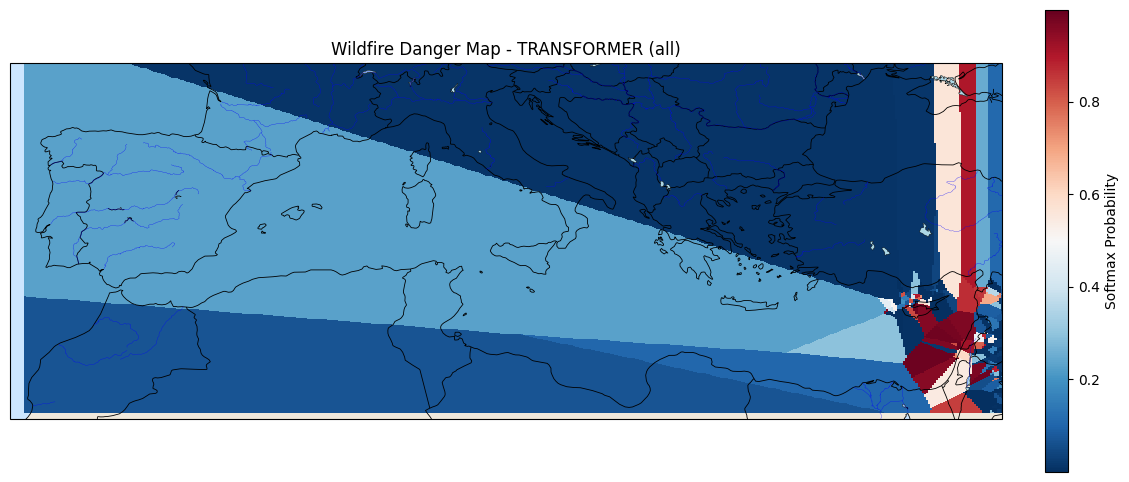

In [54]:
plot_softmax_map("transformer", "all")

In [10]:
sample_ids = [4792, 679, 8418, 1645, 1676]

for model in model_names:
    df = data_dict[model]
    selected_rows = df[df['sample_id'].isin(sample_ids)]
    print(f"\n{model.upper()} – Matching Samples:")
    print(selected_rows)



CNN – Matching Samples:
          prob        lat        lon  sample_id  label  log_burned_area
434   0.952787   4.172912  36.593164       8418      1        10.322230
529   0.270055  -6.218267  41.899512       1645      1        10.241601
650   0.992741  23.334165  38.818407       4792      1        10.844374
1910  0.413570  -6.037025  41.738409        679      1        10.389856
2312  0.812833  -7.497026  40.308615       1676      1        10.136977

MLP – Matching Samples:
          prob        lat        lon  sample_id  label  log_burned_area
800   0.992029  23.334165  38.818407       4792      1        10.844374
1362  0.772229  -7.497026  40.308615       1676      1        10.136977
1653  0.931372   4.172912  36.593164       8418      1        10.322230
1749  0.161926  -6.218267  41.899512       1645      1        10.241601
2781  0.319719  -6.037025  41.738409        679      1        10.389856

GRU – Matching Samples:
          prob        lat        lon  sample_id  label  log_b

In [10]:
data_dict['tft'][(data_dict['tft']['sample_id']==4792) | (data_dict['tft']['sample_id']==679) | (data_dict['tft']['sample_id']==8418) | (data_dict['tft']['sample_id']==1645) | (data_dict['tft']['sample_id']==1676)]

,prob,lat,lon,sample_id,label,log_burned_area
285,0.973704,4.172912,36.593164,8418,1,10.322230
940,0.182997,-6.218267,41.899512,1645,1,10.241601
1148,0.979553,23.334165,38.818407,4792,1,10.844374
2534,0.488200,-6.037025,41.738409,679,1,10.389856
2672,0.906081,-7.497026,40.308615,1676,1,10.136977
